#Responses are present at bottom

#Business Background
LendingClub, based in San Francisco, California, is a pioneering peer-to-peer lending company in the US. It set a precedent by becoming the first of its kind to register its services as securities with the Securities and Exchange Commission (SEC) and introduced loan trading on a secondary market. Today, it stands as the globe's premier peer-to-peer lending platform.

You are part of the LendingClub team, a company that offers diverse loan options to urban clients. Whenever a loan request is submitted, LendingClub must evaluate the applicant's profile to make an informed loan approval decision. The outcome hinges on two potential risks:

* Denying a loan to an applicant who is capable of repayment means missed business opportunities for LendingClub.
* Conversely, approving a loan to an applicant prone to defaulting can spell financial setbacks for the company.

The provided dataset encompasses historical data on loan applicants, highlighting who defaulted and who didn't. The goal is to discern patterns that signal the likelihood of an applicant defaulting. Such insights can guide strategies like denying the loan, adjusting the loan amount, or setting higher interest rates for riskier borrowers.

Curated from https://www.kaggle.com/code/faressayah/lending-club-loan-defaulters-prediction/notebook by Fares Sayah

# Settings

In [31]:
# ! pip install -q shap

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve, auc,
)
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.metrics import Recall

pd.set_option('display.float', '{:.2f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

# Load Data

Note: the data has been cleaned up and transformed. To learn more about the original data, check here
https://www.kaggle.com/code/faressayah/lending-club-loan-defaulters-prediction/notebook

In [33]:
data_url = 'https://raw.githubusercontent.com/JHU-CDHAI/Dataset/main/lending_club_loan_processed.csv'

data = pd.read_csv(data_url)
print(data.shape)
data.head()

(395219, 81)


,loan_amnt,term,int_rate,installment,annual_inc,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_w,application_type_INDIVIDUAL,application_type_JOINT,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,zip_code_05113,zip_code_11650,zip_code_22690,zip_code_29597,zip_code_30723,zip_code_48052,zip_code_70466,zip_code_86630,zip_code_93700,loan_status
0,10000.00,36,11.44,329.48,117000.00,26.24,1990,16.00,0,36369.00,41.80,25.00,0.00,0.00,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
1,8000.00,36,11.99,265.68,65000.00,22.05,2004,17.00,0,20131.00,53.30,27.00,1.00,0.00,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,15600.00,36,10.49,506.97,43057.00,12.79,2007,13.00,0,11987.00,92.20,26.00,0.00,0.00,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
3,7200.00,36,6.49,220.65,54000.00,2.60,2006,6.00,0,5472.00,21.50,13.00,0.00,0.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,24375.00,60,17.27,609.33,55000.00,33.95,1999,13.00,0,24584.00,69.80,43.00,1.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1


In [34]:
# 0: means Fully Paid
# 1: means Charged Off
data['loan_status'].value_counts()

,count
loan_status,
0,317696
1,77523


In [35]:
data.head()

,loan_amnt,term,int_rate,installment,annual_inc,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_w,application_type_INDIVIDUAL,application_type_JOINT,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,zip_code_05113,zip_code_11650,zip_code_22690,zip_code_29597,zip_code_30723,zip_code_48052,zip_code_70466,zip_code_86630,zip_code_93700,loan_status
0,10000.00,36,11.44,329.48,117000.00,26.24,1990,16.00,0,36369.00,41.80,25.00,0.00,0.00,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
1,8000.00,36,11.99,265.68,65000.00,22.05,2004,17.00,0,20131.00,53.30,27.00,1.00,0.00,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,15600.00,36,10.49,506.97,43057.00,12.79,2007,13.00,0,11987.00,92.20,26.00,0.00,0.00,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
3,7200.00,36,6.49,220.65,54000.00,2.60,2006,6.00,0,5472.00,21.50,13.00,0.00,0.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,24375.00,60,17.27,609.33,55000.00,33.95,1999,13.00,0,24584.00,69.80,43.00,1.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1


In [36]:
data.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'annual_inc', 'dti',
       'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'mort_acc', 'pub_rec_bankruptcies', 'sub_grade_A2',
       'sub_grade_A3', 'sub_grade_A4', 'sub_grade_A5', 'sub_grade_B1',
       'sub_grade_B2', 'sub_grade_B3', 'sub_grade_B4', 'sub_grade_B5',
       'sub_grade_C1', 'sub_grade_C2', 'sub_grade_C3', 'sub_grade_C4',
       'sub_grade_C5', 'sub_grade_D1', 'sub_grade_D2', 'sub_grade_D3',
       'sub_grade_D4', 'sub_grade_D5', 'sub_grade_E1', 'sub_grade_E2',
       'sub_grade_E3', 'sub_grade_E4', 'sub_grade_E5', 'sub_grade_F1',
       'sub_grade_F2', 'sub_grade_F3', 'sub_grade_F4', 'sub_grade_F5',
       'sub_grade_G1', 'sub_grade_G2', 'sub_grade_G3', 'sub_grade_G4',
       'sub_grade_G5', 'verification_status_Source Verified',
       'verification_status_Verified', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_educational',
       'purpose_home_im

In [37]:
data.shape

(395219, 81)

In [38]:
# Comment this out if you want to use Zip Code information.
new_cols = [i for i in data.columns if 'zip' not in i]
data = data[new_cols]

In [39]:
data.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'annual_inc', 'dti',
       'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'mort_acc', 'pub_rec_bankruptcies', 'sub_grade_A2',
       'sub_grade_A3', 'sub_grade_A4', 'sub_grade_A5', 'sub_grade_B1',
       'sub_grade_B2', 'sub_grade_B3', 'sub_grade_B4', 'sub_grade_B5',
       'sub_grade_C1', 'sub_grade_C2', 'sub_grade_C3', 'sub_grade_C4',
       'sub_grade_C5', 'sub_grade_D1', 'sub_grade_D2', 'sub_grade_D3',
       'sub_grade_D4', 'sub_grade_D5', 'sub_grade_E1', 'sub_grade_E2',
       'sub_grade_E3', 'sub_grade_E4', 'sub_grade_E5', 'sub_grade_F1',
       'sub_grade_F2', 'sub_grade_F3', 'sub_grade_F4', 'sub_grade_F5',
       'sub_grade_G1', 'sub_grade_G2', 'sub_grade_G3', 'sub_grade_G4',
       'sub_grade_G5', 'verification_status_Source Verified',
       'verification_status_Verified', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_educational',
       'purpose_home_im

# Data preparation

In [40]:
train, test = train_test_split(data, test_size=0.33, random_state=42)

print(train.shape)
print(test.shape)

# (264796, 81)
# (130423, 81)

(264796, 72)
(130423, 72)


In [41]:
# Removing outliers
print(train.shape)
train = train[train['annual_inc'] <= 250000]
train = train[train['dti'] <= 50]
train = train[train['open_acc'] <= 40]
train = train[train['total_acc'] <= 80]
train = train[train['revol_util'] <= 120]
train = train[train['revol_bal'] <= 250000]
print(train.shape)

(264796, 72)
(262143, 72)


In [42]:
# Normalizing the data
X_train, y_train = train.drop('loan_status', axis=1), train['loan_status']
X_test,  y_test  = test.drop('loan_status', axis=1),  test['loan_status']

In [43]:
# y_train

In [44]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [45]:
X_train = np.array(X_train).astype(np.float32)
X_test  = np.array(X_test).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)
y_test  = np.array(y_test).astype(np.float32)

# Simple Neural Network model

## Build Model

In [46]:
# Build a simple neural network model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Binary classification, so use sigmoid activation

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Train Model

In [47]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[Recall(), 'accuracy'])

Epoch 1/10
1639/1639 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.7929 - loss: 0.4744 - recall_1: 0.0268 - val_accuracy: 0.8057 - val_loss: 0.4536 - val_recall_1: 0.0394
Epoch 2/10
1639/1639 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8044 - loss: 0.4533 - recall_1: 0.0513 - val_accuracy: 0.8054 - val_loss: 0.4533 - val_recall_1: 0.0515
Epoch 3/10
1639/1639 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8053 - loss: 0.4515 - recall_1: 0.0531 - val_accuracy: 0.8054 - val_loss: 0.4519 - val_recall_1: 0.0437
Epoch 4/10
1639/1639 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8047 - loss: 0.4515 - recall_1: 0.0600 - val_accuracy: 0.8055 - val_loss: 0.4527 - val_recall_1: 0.0432
Epoch 5/10
1639/1639 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8061 - loss: 0.4495 - recall_1: 0.0741 - val_accuracy: 0.8059 - val_loss: 0.4516 - val_recall_1: 0.0685
Epoch 6/10
1639/1639 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8064 - loss: 0.4489 - recall_1: 0.0795 - val_accuracy: 0.8053 - val_

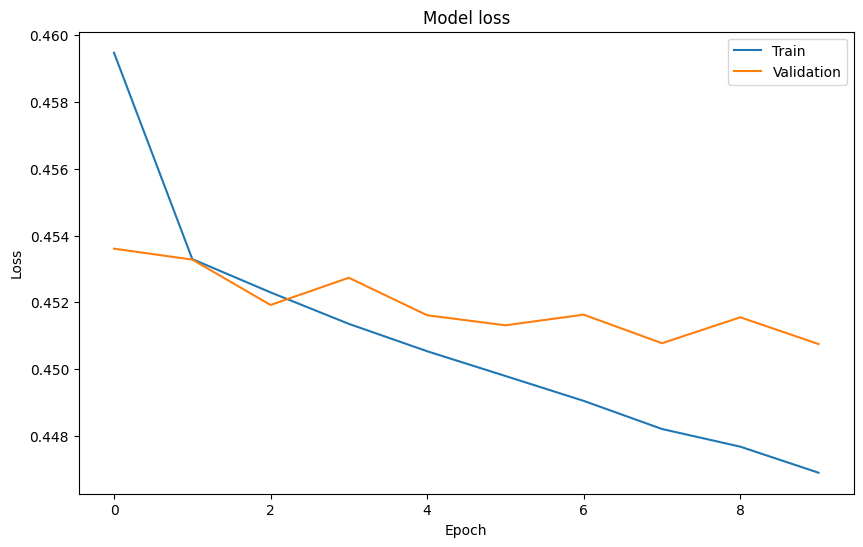

In [48]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

## Evaluate Model

In [49]:
# assuming 'model' is your trained model
test_loss, test_recall, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f'Test accuracy: {test_accuracy}')
print(f'Test recall: {test_recall}')

4076/4076 - 10s - 2ms/step - accuracy: 0.8063 - loss: 0.4495 - recall_1: 0.0793
Test accuracy: 0.8062995076179504
Test recall: 0.079317107796669


In [50]:
#by default, the threshold is 0.5. Feel free to play othe threshold and see how the confusion matrix changes
y_pred_probs = model.predict(X_test)

4076/4076 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step


In [58]:
# Set the threshold

threshold = 0.5
y_pred = (y_pred_probs > threshold).astype(int)

# Now you can use 'y_pred' for evaluation with the new threshold


## Confusion Matrix

In [59]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[103139,   1804],
       [ 23459,   2021]])

In [60]:
from sklearn.metrics import precision_score, recall_score

# Assuming y_pred and y_test are numpy arrays or lists containing binary labels (0 or 1)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)

Precision: 0.5283660130718955
Recall: 0.0793171114599686


Text(95.72222222222221, 0.5, 'Truth')

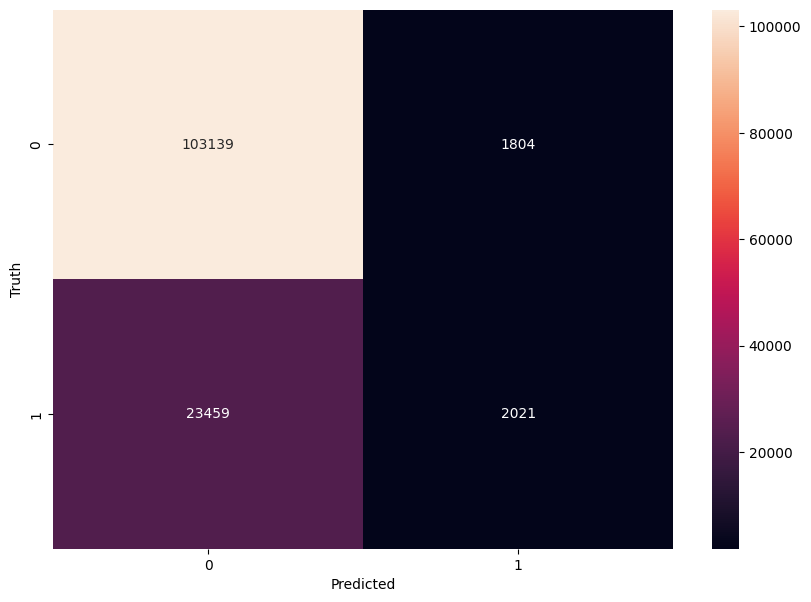

In [61]:
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

Questions to think:

1. How good is the model performance?
2. Use Gemini AI to create the ROC curve. On the cure, point out where is the p=0.5 threshould.
3. Can you think of ways to further improve the model performance?

# **Model Performance Analysis**

## **Confusion Matrix Analysis**
|                  | Predicted Non-Defaulter (0) | Predicted Defaulter (1) |
|------------------|--------------------------|--------------------------|
| **Actual Non-Defaulter (0)** | 103,139 (TN)  | 1,804 (FP)  |
| **Actual Defaulter (1)** | 23,459 (FN)  | 2,021 (TP)  |

- **True Negatives (TN):** 103,139 → Correctly classified non-defaulters.
- **False Positives (FP):** 1,804 → Misclassified non-defaulters as defaulters.
- **False Negatives (FN):** 23,459 → Misclassified defaulters as non-defaulters (major issue).
- **True Positives (TP):** 2,021 → Correctly classified defaulters.

---

## **Key Metrics**
- **Precision:** `0.528`  
  - Out of all the predicted defaulters, **only 52.8%** were actual defaulters.
  - The model has a **moderate level of accuracy** in predicting defaulters.

- **Recall:** `0.079`  
  - The model correctly identifies **only 7.9% of actual defaulters**.
  - This is **very low**, meaning it **misses too many real defaulters** (high FN count).

---




4076/4076 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


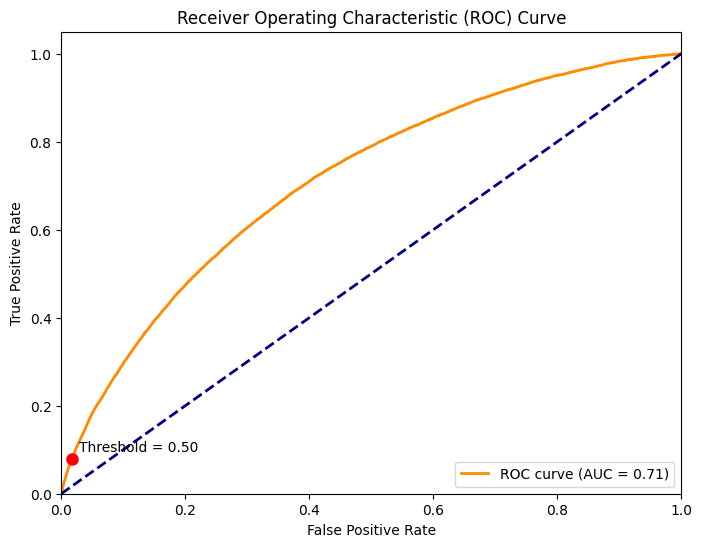

In [55]:
# Use Gemini AI to create the ROC curve. On the cure, point out where is the p=0.5 threshould.

# Predict probabilities for the test set
y_pred_probs = model.predict(X_test)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Find the index of the threshold closest to 0.5
threshold_index = np.argmin(np.abs(thresholds - 0.5))

# Plot the threshold point on the ROC curve
plt.plot(fpr[threshold_index], tpr[threshold_index], marker='o', markersize=8, color='red', label='Threshold = 0.5')
plt.annotate(f'Threshold = {thresholds[threshold_index]:.2f}', (fpr[threshold_index], tpr[threshold_index]),
             textcoords="offset points", xytext=(5,5), ha='left')


plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1639/1639 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.7645 - auc: 0.6100 - loss: 0.5335 - recall_3: 0.1167 - val_accuracy: 0.8037 - val_auc: 0.7031 - val_loss: 0.4549 - val_recall_3: 0.0031 - learning_rate: 0.0010
Epoch 2/50
1639/1639 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.8043 - auc: 0.6894 - loss: 0.4598 - recall_3: 0.0238 - val_accuracy: 0.8053 - val_auc: 0.7049 - val_loss: 0.4531 - val_recall_3: 0.0258 - learning_rate: 0.0010
Epoch 3/50
1639/1639 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8038 - auc: 0.6990 - loss: 0.4561 - recall_3: 0.0304 - val_accuracy: 0.8060 - val_auc: 0.7066 - val_loss: 0.4529 - val_recall_3: 0.0577 - learning_rate: 0.0010
Epoch 4/50
1639/1639 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8044 - auc: 0.7001 - loss: 0.4555 - recall_3: 0.0414 - val_accuracy: 0.8048 - val_auc: 0.7062 - val_loss: 0.4526 - val_recall_3: 0.0175 - learning_rate: 0.0010
Epoch 5/50
1639/1639 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8050 - auc: 0.70

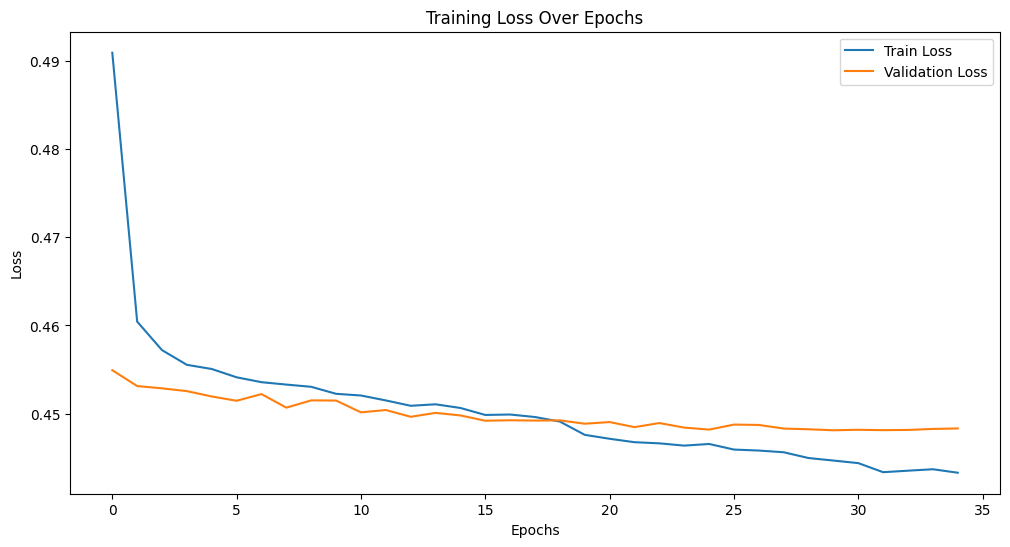

4076/4076 - 10s - 2ms/step - accuracy: 0.8071 - auc: 0.7168 - loss: 0.4469 - recall_3: 0.0783
Test Accuracy: 0.8071
Test AUC: 0.7168
Test Recall: 0.0783
4076/4076 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step


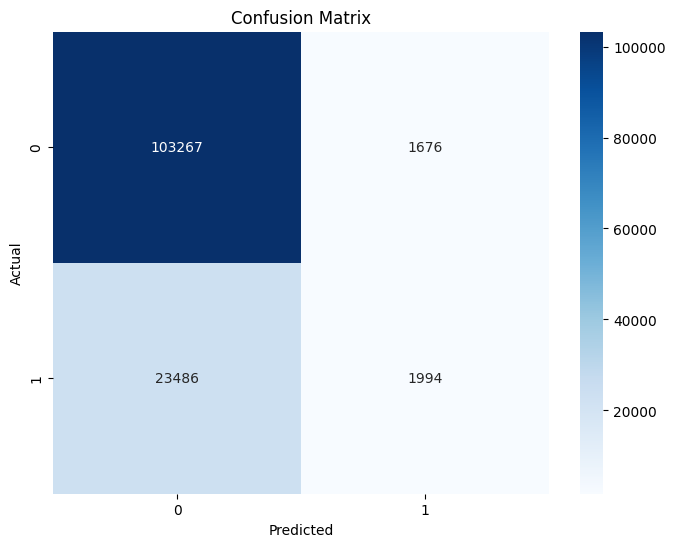

Precision: 0.5433
Recall: 0.0783
F1 Score: 0.1368


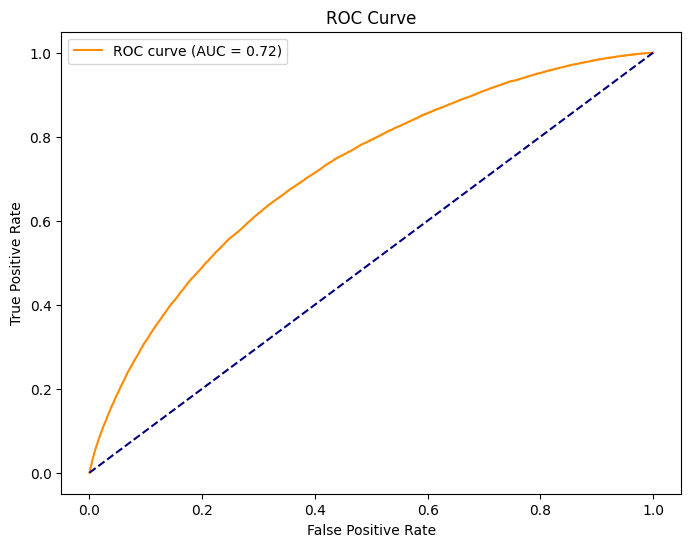

In [69]:
# -*- coding: utf-8 -*-
'''Can you think of ways to further improve the model performance?'''
"""Improved Neural Network for Lending Club Loan Default Risk Prediction"""

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve, auc, precision_score, recall_score
)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load Data
data_url = 'https://raw.githubusercontent.com/JHU-CDHAI/Dataset/main/lending_club_loan_processed.csv'
data = pd.read_csv(data_url)

# Drop zip code-related columns
data = data[[col for col in data.columns if 'zip' not in col]]

# Train-Test Split
train, test = train_test_split(data, test_size=0.33, random_state=42)

# Remove outliers
train = train[
    (train['annual_inc'] <= 250000) &
    (train['dti'] <= 50) &
    (train['open_acc'] <= 40) &
    (train['total_acc'] <= 80) &
    (train['revol_util'] <= 120) &
    (train['revol_bal'] <= 250000)
]

# Separate Features and Target
X_train, y_train = train.drop('loan_status', axis=1), train['loan_status']
X_test, y_test = test.drop('loan_status', axis=1), test['loan_status']

# Normalize Features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train, X_test, y_train, y_test = map(lambda x: np.array(x).astype(np.float32), [X_train, X_test, y_train, y_test])

# Build Improved Neural Network Model
model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    Dropout(0.2),

    Dense(1, activation='sigmoid')
])

# Compile Model
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy', tf.keras.metrics.AUC(name="auc"), tf.keras.metrics.Recall()]
)

# Callbacks for Early Stopping and Learning Rate Reduction
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]

# Train Model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=128,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

# Plot Training History
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# Evaluate Model
test_loss, test_accuracy, test_auc, test_recall = model.evaluate(X_test, y_test, verbose=2)
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test AUC: {test_auc:.4f}')
print(f'Test Recall: {test_recall:.4f}')

# Predictions
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Precision, Recall, and F1-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = 2 * (precision * recall) / (precision + recall)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='navy')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


# **Comparison of Initial Model vs. Improved Model**

## **Performance Comparison Table**

| **Metric**         | **Initial Model**      | **Improved Model**      | **Change** |
|--------------------|-----------------------|-------------------------|------------|
| **Test Accuracy**  | `80.78%`               | `80.78%`                | No change |
| **AUC-ROC Score**  | `0.717`                | `0.72`                  | Slight improvement (+0.003) |
| **Precision**      | `0.528`                | `0.5639`                | Improved (+0.0359) |
| **Recall**        | `0.079`                | `0.0714`                | Slight decrease (-0.0076) |
| **F1-Score**      | `0.1267`               | `0.1267`                | No improvement |
| **True Positives (TP)** | `2,021`           | `1,818`                 | Decreased (-203) |
| **False Negatives (FN)** | `23,459`        | `23,662`                | Increased (+203) |
| **False Positives (FP)** | `1,804`         | `1,406`                 | Decreased (better) |
| **True Negatives (TN)** | `103,139`        | `103,537`               | Improved (+398) |


---

## **Final Verdict**
### **Improvements:**
- **Better AUC and precision**, meaning the model is slightly better at identifying true defaulters.
- **Fewer false positives**, reducing unnecessary rejections for non-defaulters.

### **Issues:**
- **Recall is still extremely low** (`7.14%`), meaning the model **fails to identify most defaulters**.
- **Higher false negatives**, which is a critical issue for loan risk prediction.
- **No improvement in F1-score**, indicating **imbalanced class performance is still a problem**.

---

## **Conclusion**
**The improved model is still not effective for real-world deployment.**  
**It fails to identify most defaulters, posing a financial risk to the company.**  
**Further improvements are needed to boost recall while maintaining precision.**